### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from scipy import stats
import os
from tqdm import tqdm
import utils
from joblib import Parallel, delayed
import multiprocessing
import subprocess
import io

### Audio Preprocessing

In [2]:
# --- Configuração ---
METADATA_DIR = '../fma_metadata'
AUDIO_DIR_GENRES = '../fma_datasets/fma_small_genres'

# Arquivos de cache para os espectrogramas
FEATURE_FILE_X = '../preprocessed_features/fma_small_spectrograms_X_5s_25overlap.npy'
FEATURE_FILE_y = '../preprocessed_features/fma_small_spectrograms_y_5s_25overlap.npy'
FEATURE_FILE_groups = '../preprocessed_features/fma_small_spectrograms_groups_5s_25overlap.npy'
N_CLASSES = 8 # 8 gêneros no fma_small

# --- Carregar Metadados (Igual ao v2) ---
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')

small_mask = tracks[('set', 'subset')] == 'small'
y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')]
splits_pd = tracks.loc[small_mask, ('set', 'split')]

# --- Codificar os Gêneros (Labels) ---
label_encoder = LabelEncoder()
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32)
class_names = label_encoder.classes_

# --- Criar DataFrame de referência ---
track_metadata = pd.DataFrame({
    'genre_top': y_all_labels_pd,
    'genre_encoded': y_all_encoded_np,
    'split': splits_pd
}, index=y_all_labels_pd.index)

print(f"Metadados carregados para {track_metadata.shape[0]} faixas 'small'.")
print(f"Gêneros: {class_names}")

Metadados carregados para 8000 faixas 'small'.
Gêneros: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


In [3]:
# --- 1. Função de Carregamento Robusto ---
def load_audio_ffmpeg(file_path, sr):
    """
    Decodifica áudio para WAV em memória usando FFmpeg.
    Muito mais robusto a arquivos MP3 corrompidos do FMA.
    """
    try:
        # Comando para decodificar MP3 para WAV (PCM 16-bit) e jogar no STDOUT (pipe)
        command = [
            'ffmpeg',
            '-i', file_path,
            '-f', 'wav',            # Formato de contêiner WAV
            '-ac', '1',             # 1 Canal (Mono)
            '-ar', str(sr),         # Taxa de Amostragem
            '-vn',                  # Ignorar vídeo (se houver capa de álbum embutida)
            '-y',                   # Sobrescrever (para pipe não importa, mas boa prática)
            '-loglevel', 'quiet',   # Silenciar logs do ffmpeg
            '-'                     # Saída para Pipe (STDOUT)
        ]
        
        # Executa e captura os bytes
        out = subprocess.check_output(command)
        
        # Carrega do buffer de memória
        # librosa.load consegue ler de um objeto file-like (BytesIO)
        y, _ = librosa.load(io.BytesIO(out), sr=sr)
        
        return y
        
    except Exception as e:
        # Fallback: Se o FFmpeg falhar (raro), tenta o librosa padrão ou retorna erro
        # print(f"Erro FFmpeg em {file_path}: {e}")
        try:
            y, _ = librosa.load(file_path, sr=sr, mono=True)
            return y
        except:
            return None

In [4]:
# Parâmetros de Janelamento e Espectrograma
WINDOW_SIZE_SEC = 5
OVERLAP_PERCENT = 0.25
SR = 22050
N_MELS = 128   # Altura da "imagem" do espectrograma
N_FFT = 2048
HOP_LENGTH = 512 # Resultará na "largura" da imagem

# CALCULA A LARGURA FIXA (shape[1])
SPEC_WIDTH = int(np.ceil((WINDOW_SIZE_SEC * SR) / HOP_LENGTH))
SPEC_SHAPE = (N_MELS, SPEC_WIDTH)

def gerar_melspectrogram_janelado(file_path, sr=SR, window_size_sec=WINDOW_SIZE_SEC, overlap_percent=OVERLAP_PERCENT, target_shape=SPEC_SHAPE, n_fft=N_FFT, hop_length=HOP_LENGTH):
    all_window_specs = []
    
    try:
        y = load_audio_ffmpeg(file_path, sr=sr)

        # Verificação de segurança caso o ffmpeg falhe e retorne None
        if y is None:
            return []
        
        samples_per_window = window_size_sec * sr
        hop_size = int(samples_per_window * (1.0 - overlap_percent))
        
        if len(y) < samples_per_window:
            #print(f"Aviso: Áudio {file_path} mais curto que {window_size_sec}s. Pulando.")
            return []

        # Cria as janelas (frames) com sobreposição
        y_frames = librosa.util.frame(y, frame_length=samples_per_window, hop_length=hop_size, axis=0)
        
        for y_window in y_frames:
            # Gera o Mel-Espectrograma para a janela
            S = librosa.feature.melspectrogram(y=y_window, sr=sr, n_mels=target_shape[0], n_fft=n_fft, hop_length=hop_length)
            # Converte para dB
            S_db = librosa.power_to_db(S, ref=np.max)
            
            # Garante que a "largura" do espectrograma seja consistente
            # Isso evita o erro de "pickle" do NumPy
            S_db = librosa.util.fix_length(S_db, size=target_shape[1], axis=1)
            
            all_window_specs.append(S_db.astype(np.float32)) # Salva como float32
            
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return []
        
    return all_window_specs

In [5]:
# Define o número de núcleos a usar (deixa 1 ou 2 livres para o sistema/OS não travar)
N_JOBS = max(1, multiprocessing.cpu_count() - 2)

# Funções Auxiliares para o Paralelismo (devem ser definidas antes da chamada Parallel)
def worker_count_windows(args):
    """Função worker para contar janelas de uma faixa em paralelo"""
    track_id, row, audio_dir = args
    genre_top = row['genre_top']
    file_path = f"{audio_dir}/{genre_top}/{track_id:06d}.mp3"
    
    if not os.path.exists(file_path):
        return None
    
    # Reutiliza a lógica de contagem (copiada para dentro para garantir escopo no worker)
    try:
        y = load_audio_ffmpeg(file_path, sr=SR)
        
        if y is None: 
            return None
    
        samples_per_window = WINDOW_SIZE_SEC * SR
        if len(y) < samples_per_window: 
            return None
        
        hop_size = int(samples_per_window * (1.0 - OVERLAP_PERCENT))
        n_windows = librosa.util.frame(y, frame_length=samples_per_window, hop_length=hop_size, axis=0).shape[0]

        return (track_id, row, n_windows)
    
    except Exception:
        return None

def worker_extract_features(args):
    """Função worker para extrair mel-specs de uma faixa em paralelo"""
    track_id, row, n_janelas_esperadas, audio_dir = args
    genre_top = row['genre_top']
    file_path = f"{audio_dir}/{genre_top}/{track_id:06d}.mp3"
    
    window_specs = gerar_melspectrogram_janelado(file_path)
    
    # Prepara os dados para retorno
    track_data = []
    for i, spec in enumerate(window_specs):
        if i >= n_janelas_esperadas: break
        # Retorna tupla: (Espectrograma, Label Codificado, Track ID)
        track_data.append((spec, row['genre_encoded'], track_id))
        
    return track_data

In [6]:
# Para garantir que as variáveis existam fora do escopo do 'if'
X_np = None
y_encoded_np = None
groups_np = None

# Verifica se os arquivos de cache existem
if not (os.path.exists(FEATURE_FILE_X) and 
        os.path.exists(FEATURE_FILE_y) and 
        os.path.exists(FEATURE_FILE_groups)):
    
    print(f"Arquivos de espectrograma não encontrados na cache. Iniciando extração (são 2 passagens)...")
    print(f"Extração paralela usando {N_JOBS} núcleos...")

    print("Passagem 1/2: Contando janelas...")

    # --- 2 - Contagem Paralela ---
    # Prepara argumentos para o worker
    tasks_p1 = [(tid, row, AUDIO_DIR_GENRES) for tid, row in track_metadata.iterrows()]
    
    # Executa em paralelo
    results_p1 = Parallel(n_jobs=N_JOBS, verbose=5, batch_size='auto')(
        delayed(worker_count_windows)(t) for t in tqdm(tasks_p1, desc="Passagem 1/2: Contando Janelas")
    )

    total_janelas = 0
    all_track_ids_para_contagem = [] # Usado para saber quais faixas processar na Passagem 2
    
    for res in results_p1:
        if res is not None:
            track_id, row, n = res
            if n > 0:
                total_janelas += n
                all_track_ids_para_contagem.append((track_id, row, n))
                
    print(f"Contagem completa! Total de janelas a serem extraídas: {total_janelas}")
    
    # --- 2 - Extração Paralela ---
    tasks_p2 = [(t[0], t[1], t[2], AUDIO_DIR_GENRES) for t in all_track_ids_para_contagem]
    
    # Executa extração (Isso vai consumir RAM, mas com 32GB é tranquilo para ~7GB de dados)
    results_p2_lists = Parallel(n_jobs=N_JOBS, batch_size='auto')(
        delayed(worker_extract_features)(t) for t in tqdm(tasks_p2, desc="Passagem 2/2: Extraindo Features")
    )
    
    # --- 3 - Escrita no Memmap ---
    # Agora escrevemos tudo no disco sequencialmente (muito rápido pois já está na RAM)
    # Cria os arrays no disco (np.memmap para X)
    os.makedirs(os.path.dirname(FEATURE_FILE_X), exist_ok=True)
    
    # Criamos um nome temporário para o arquivo memmap
    MEMMAP_TEMP_FILE = FEATURE_FILE_X + '.temp'
    if os.path.exists(MEMMAP_TEMP_FILE):
        os.remove(MEMMAP_TEMP_FILE)

    final_shape = (total_janelas, SPEC_SHAPE[0], SPEC_SHAPE[1])
    print(f"\nEscrevendo dados no disco para {MEMMAP_TEMP_FILE} shape={final_shape}...")
        
    X_np_memmap = np.memmap(MEMMAP_TEMP_FILE, dtype='float32', mode='w+', shape=final_shape)
    y_encoded_np_temp = np.zeros(total_janelas, dtype=np.int32)
    groups_np_temp = np.zeros(total_janelas, dtype=np.int32)

    print(f"Passagem 2/2: Extraindo espectrogramas para {MEMMAP_TEMP_FILE} (Shape: {final_shape})...")
    
    idx_escrita = 0
    # Itera sobre os resultados das faixas
    for track_data in tqdm(results_p2_lists, desc="Salvando no disco..."):
        for spec, label, tid in track_data:
            X_np_memmap[idx_escrita] = spec
            y_encoded_np_temp[idx_escrita] = label
            groups_np_temp[idx_escrita] = tid
            idx_escrita += 1
    
    # Finalização (Salvar e Carregar)
    print(f"\nConsolidando arquivos...")
    print(f"\nConvertendo {MEMMAP_TEMP_FILE} para {FEATURE_FILE_X}...")
    np.save(FEATURE_FILE_X, X_np_memmap) # Converte memmap para npy final
    del X_np_memmap
    if os.path.exists(MEMMAP_TEMP_FILE): os.remove(MEMMAP_TEMP_FILE)
    
    np.save(FEATURE_FILE_y, y_encoded_np_temp)
    np.save(FEATURE_FILE_groups, groups_np_temp)
    
    print("Carregando arquivos gerados...")
    X_np = np.load(FEATURE_FILE_X, mmap_mode='r')
    y_encoded_np = np.load(FEATURE_FILE_y)
    groups_np = np.load(FEATURE_FILE_groups)

else:
    print(f"Carregando espectrogramas cacheados de {FEATURE_FILE_X}...")
    # Carrega do disco (usando mmap_mode='r')
    X_np = np.load(FEATURE_FILE_X, mmap_mode='r')
    y_encoded_np = np.load(FEATURE_FILE_y)
    groups_np = np.load(FEATURE_FILE_groups)
    print("Arquivos carregados.")

# Estas linhas agora funcionarão
print(f"Shape de X (amostras, n_mels, frames): {X_np.shape}")
print(f"Shape de y (labels): {y_encoded_np.shape}")
print(f"Shape de groups (track_ids): {groups_np.shape}")

Arquivos de espectrograma não encontrados na cache. Iniciando extração (são 2 passagens)...
Extração paralela usando 14 núcleos...
Passagem 1/2: Contando janelas...


Passagem 1/2: Contando Janelas:  56%|█████▌    | 4480/8000 [01:02<00:45, 77.41it/s][src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/tmp/ipykernel_1732/3990897043.py:34: UserWarning: PySoundFile failed. Trying audioread instead.
/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Passagem 1/2: Contando Janelas:  61%|██████▏   | 4914/8000 [01:08<00:41, 74.20it/s][src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
/tmp/ipykernel_1732/3990897043.py:34: UserWarning: PySoundFile failed. Trying audioread instead.
/home/zurua/miniconda3/envs/tcc_cnn/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audiorea

Contagem completa! Total de janelas a serem extraídas: 55958


Passagem 2/2: Extraindo Features: 100%|██████████| 7994/7994 [02:36<00:00, 51.18it/s]



Escrevendo dados no disco para ../preprocessed_features/fma_small_spectrograms_X_5s_25overlap.npy.temp shape=(55958, 128, 216)...
Passagem 2/2: Extraindo espectrogramas para ../preprocessed_features/fma_small_spectrograms_X_5s_25overlap.npy.temp (Shape: (55958, 128, 216))...


Salvando no disco...: 100%|██████████| 7994/7994 [00:06<00:00, 1151.77it/s]



Consolidando arquivos...

Convertendo ../preprocessed_features/fma_small_spectrograms_X_5s_25overlap.npy.temp para ../preprocessed_features/fma_small_spectrograms_X_5s_25overlap.npy...
Carregando arquivos gerados...
Shape de X (amostras, n_mels, frames): (55958, 128, 216)
Shape de y (labels): (55958,)
Shape de groups (track_ids): (55958,)


### Treino dos Modelos

In [7]:
import os
# Desabilita otimizações XLA que podem consumir memória extra na compilação
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

import tensorflow as tf

# Configuração crítica para evitar travamento em GPUs com pouca VRAM (6GB)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Memory Growth habilitado para: {gpus}")
    except RuntimeError as e:
        print(e)

2025-12-08 04:44:52.822409: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 04:44:53.434830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 04:44:57.387587: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU Memory Growth habilitado para: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, LSTM,
                                     BatchNormalization, Dropout, Reshape,
                                     Permute, Dense, Activation, Bidirectional)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW

# Adiciona a dimensão do "canal" (1, pois é escala de cinza/monocromático)
X_np_cnn = X_np[..., np.newaxis]

# Converte labels para one-hot encoding
y_one_hot = tf.keras.utils.to_categorical(y_encoded_np, num_classes=N_CLASSES)

print(f"Shape de X para CNN (amostras, altura, largura, canais): {X_np_cnn.shape}")
print(f"Shape de y (one-hot): {y_one_hot.shape}")

Shape de X para CNN (amostras, altura, largura, canais): (55958, 128, 216, 1)
Shape de y (one-hot): (55958, 8)


In [9]:
def build_crnn_model(input_shape, num_classes):
    """
    CRNN: CNN para extração de features + LSTM para dependência temporal.
    """
    inputs = Input(shape=input_shape, name='input_audio')

    # --- Estágio 1: CNN (Feature Extraction) ---
    # O objetivo aqui é reduzir a dimensão de Frequência (128) 
    # mas manter a dimensão de Tempo (431) relativamente alta.
    
    # Bloco 1
    x = Conv2D(64, (3, 3), padding='same', name='conv1')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Pooling apenas na Frequência (2, 1) ou moderado no tempo (2, 2)
    x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x) 
    
    # Bloco 2
    x = Conv2D(128, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
    
    # Bloco 3
    x = Conv2D(256, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
    
    # Bloco 4 (Deep Features)
    x = Conv2D(512, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Aqui fazemos pool agressivo na frequência para ela sumir ou ficar pequena
    # pool_size=(4, 1) reduz frequência em 4x, mantém tempo intacto
    x = MaxPooling2D(pool_size=(4, 1), name='pool4')(x)

    # --- Estágio 2: Preparação para RNN (Reshape) ---
    # Shape atual (Batch, Freq, Time, Channels) -> (Batch, H, W, C)
    # Precisamos transformar em (Batch, Time, Features) para a LSTM
    
    # 1. Permutar para colocar o Tempo na dimensão 1: (Batch, Time, Freq, Channels)
    x = Permute((2, 1, 3), name='permute')(x)
    
    # 2. Reshape para fundir Frequência e Canais em um vetor de features por timestep
    # Novo shape: (Batch, Time, Freq * Channels)
    shape = x.shape
    x = Reshape((-1, shape[2] * shape[3]), name='reshape_to_rnn')(x)
    
    # --- Estágio 3: RNN (Temporal Modelling) ---
    # Bidirectional permite ver o passado e o futuro da música
    x = Bidirectional(LSTM(64, return_sequences=True), name='lstm1')(x)
    x = Dropout(0.3)(x)
    # Return sequences=False pega apenas o último estado (resumo da música inteira)
    x = Bidirectional(LSTM(64, return_sequences=False), name='lstm2')(x)
    
    # --- Estágio 4: Classificação ---
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name='output')(x)
    
    return Model(inputs, outputs, name="CRNN_Music_Genre")

# Pega o shape de uma amostra (altura, largura, canais)
input_shape = X_np_cnn.shape[1:] 
model_cnn = build_crnn_model(input_shape, N_CLASSES)
model_cnn.summary()

I0000 00:00:1765183498.355633    1732 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "CRNN_Music_Genre"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_audio (InputLayer)        │ (None, 128, 216, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 216, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 216, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 216, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 108, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 108, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 108, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 54, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 54, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 54, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 27, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 27, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 27, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 4, 27, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 27, 4, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_to_rnn (Reshape)        │ (None, 27, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 27, 128)        │     1,081,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,25

 Total params: 2,743,112 (10.46 MB)

 Trainable params: 2,741,192 (10.46 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import mixed_precision
import gc

# Isso usa float16 para cálculos pesados e float32 para variáveis, economizando VRAM.
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed Precision ativado: mixed_float16")

n_splits = 10
gkf = GroupKFold(n_splits=n_splits)

# Armazenar resultados
fold_scores_acc_window = []
fold_scores_acc_track = []
all_preds_track = []
all_true_track = []

BATCH_SIZE = 32 # Reduzido para garantir estabilidade na RTX 3060

def apply_spec_augment(spectrogram, time_mask_param=20, freq_mask_param=15, num_masks=1):
    """
    Aplica mascaramento de tempo e frequência no espectrograma.
    Entrada: (128, 130, 1) ou (128, 130)
    """
    # Garante que é uma cópia para não alterar o original
    aug_spec = spectrogram.copy()
    
    # Se tiver canal (H, W, C), remove para processar
    if aug_spec.ndim == 3:
        aug_spec = aug_spec[:, :, 0]
        
    n_mels, n_steps = aug_spec.shape
    
    # Mascaramento de Frequência
    for _ in range(num_masks):
        f = np.random.randint(0, freq_mask_param)
        f0 = np.random.randint(0, n_mels - f)
        aug_spec[f0:f0+f, :] = 0
        
    # Mascaramento de Tempo
    for _ in range(num_masks):
        t = np.random.randint(0, time_mask_param)
        t0 = np.random.randint(0, n_steps - t)
        aug_spec[:, t0:t0+t] = 0
        
    # Retorna dimensão do canal
    return aug_spec[..., np.newaxis]

# Função do Gerador (Mesma lógica, apenas garantindo consistência)
def data_generator(indices, batch_size, augment=False):
    num_samples = len(indices)
    while True:
        indices_shuffled = shuffle(indices)
        for offset in range(0, num_samples, batch_size):
            batch_indices = indices_shuffled[offset:offset + batch_size]

            # Carrega do disco (memmap)
            X_batch = X_np_cnn[batch_indices]
            y_batch = y_one_hot[batch_indices]
            
            # O Scaler deve ser aplicado na versão achatada e depois reshape (reshape para 2D -> transform -> reshape volta)
            # (Assumindo que o scaler foi fitado no loop principal)
            original_shape = X_batch.shape
            X_b_flat = X_batch.reshape(original_shape[0], -1)
            X_b_scaled = scaler.transform(X_b_flat).reshape(original_shape)
            
            # Aplica Augmentation apenas no Treino
            if augment:
                X_b_final = np.array([apply_spec_augment(x) for x in X_b_scaled])
            else:
                X_b_final = X_b_scaled
            
            yield X_b_final, y_batch

# Loop de Validação Cruzada (GroupKFold)
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_np_cnn, y_one_hot, groups=groups_np)):
    print(f"\n=== Iniciando Fold {fold+1}/{n_splits} ===")
    
    # Limpeza de memória preventiva
    tf.keras.backend.clear_session()
    gc.collect()

    # 1. Ajustar Scaler (StandardScaler)
    print("Ajustando o Scaler (partial_fit)...")
    scaler = StandardScaler()
    train_idx_shuffled = shuffle(train_idx)
    chunk_size = 5000   # Ajusta o scaler em lotes de 5000 amostras, para não estourar a RAM

    for i in range(0, len(train_idx_shuffled), chunk_size):
        idx = train_idx_shuffled[i:i+chunk_size]
        X_chunk = X_np_cnn[idx].reshape(len(idx), -1)
        scaler.partial_fit(X_chunk)
        del X_chunk

    print("Scaler ajustado.")

    # 2. Preparar Validação
    print("Preparando validação...")
    X_test = X_np_cnn[test_idx]
    y_test = y_one_hot[test_idx]
    X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

    # Liberar memória das cópias não usadas
    del X_test
    gc.collect()

    # Dados auxiliares para votação
    groups_test_fold = groups_np[test_idx]
    y_true_labels_fold = y_encoded_np[test_idx]
    
    # 3. Callbacks e Compilação 
    # Recriamos o modelo do zero a cada fold para não vazar pesos
    model_cnn = build_crnn_model(input_shape, N_CLASSES)
    
    # Usando AdamW para melhor generalização
    optimizer = AdamW(learning_rate=0.001, weight_decay=0.004)
    
    model_cnn.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    # ReduceLROnPlateau: Reduz LR se val_loss não melhorar por 3 épocas
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # 4. Treino com SpecAugmentation
    train_gen = data_generator(train_idx, BATCH_SIZE, augment=True)
    steps_per_epoch = len(train_idx) // BATCH_SIZE
    
    print(f"Treinando com Batch Size: {BATCH_SIZE}...")
    history = model_cnn.fit(
        train_gen,
        epochs=60,
        steps_per_epoch=steps_per_epoch,
        validation_data=(X_test_scaled, y_test),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
    
    # 5. Avaliação (Janela)
    loss, acc = model_cnn.evaluate(X_test_scaled, y_test, verbose=0)
    fold_scores_acc_window.append(acc)

    # 6. Avaliação (Faixa - Votação Majoritária)
    # Predição em batches para economizar VRAM na inferência
    y_pred_probs = model_cnn.predict(X_test_scaled, batch_size=32, verbose=0)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    
    df_fold = pd.DataFrame({
        'track_id': groups_test_fold,
        'y_true': y_true_labels_fold,
        'y_pred': y_pred_labels
    })
    
    grouped = df_fold.groupby('track_id')
    y_true_track = grouped['y_true'].first()
    y_pred_track = grouped['y_pred'].apply(lambda x: stats.mode(x, keepdims=True)[0][0])
    
    acc_track = np.mean(y_true_track == y_pred_track)
    fold_scores_acc_track.append(acc_track)
    
    print(f"Fold {fold+1}: Acc Janela={acc:.4f} | Acc Faixa={acc_track:.4f}")
    
    # Armazenar predições globais
    all_preds_track.append(y_pred_track.values)
    all_true_track.append(y_true_track.values)
    
    # Limpeza final do fold
    del model_cnn, scaler, X_test_scaled, y_test, y_pred_probs, df_fold
    tf.keras.backend.clear_session()
    gc.collect()

print("\n--- CV Concluído ---")

Mixed Precision ativado: mixed_float16

=== Iniciando Fold 1/10 ===
Ajustando o Scaler (partial_fit)...
Scaler ajustado.
Preparando validação...
Treinando com Batch Size: 32...
Epoch 1/60


2025-12-08 04:45:23.479692: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


1573/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3397 - loss: 1.7631

2025-12-08 04:49:10.299771: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1573/1573 ━━━━━━━━━━━━━━━━━━━━ 236s 146ms/step - accuracy: 0.4055 - loss: 1.6391 - val_accuracy: 0.4775 - val_loss: 1.4436 - learning_rate: 0.0010
Epoch 2/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 228s 144ms/step - accuracy: 0.5197 - loss: 1.4051 - val_accuracy: 0.5409 - val_loss: 1.3465 - learning_rate: 0.0010
Epoch 3/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 227s 144ms/step - accuracy: 0.5574 - loss: 1.3032 - val_accuracy: 0.5479 - val_loss: 1.3118 - learning_rate: 0.0010
Epoch 4/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 217s 138ms/step - accuracy: 0.5828 - loss: 1.2322 - val_accuracy: 0.5175 - val_loss: 1.5216 - learning_rate: 0.0010
Epoch 5/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 217s 138ms/step - accuracy: 0.6056 - loss: 1.1743 - val_accuracy: 0.5454 - val_loss: 1.4265 - learning_rate: 0.0010
Epoch 6/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6205 - loss: 1.1329
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 217s 138ms/step - accura

2025-12-08 13:11:07.572068: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1573/1573 ━━━━━━━━━━━━━━━━━━━━ 232s 145ms/step - accuracy: 0.4053 - loss: 1.6479 - val_accuracy: 0.4282 - val_loss: 1.6934 - learning_rate: 0.0010
Epoch 2/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 220s 139ms/step - accuracy: 0.5187 - loss: 1.4006 - val_accuracy: 0.5308 - val_loss: 1.3543 - learning_rate: 0.0010
Epoch 3/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 217s 138ms/step - accuracy: 0.5557 - loss: 1.3002 - val_accuracy: 0.4327 - val_loss: 1.6210 - learning_rate: 0.0010
Epoch 4/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 221s 141ms/step - accuracy: 0.5830 - loss: 1.2301 - val_accuracy: 0.5721 - val_loss: 1.2843 - learning_rate: 0.0010
Epoch 5/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 227s 144ms/step - accuracy: 0.6003 - loss: 1.1804 - val_accuracy: 0.5060 - val_loss: 1.4111 - learning_rate: 0.0010
Epoch 6/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 227s 145ms/step - accuracy: 0.6210 - loss: 1.1266 - val_accuracy: 0.5684 - val_loss: 1.2998 - learning_rate: 0.0010
Epoch 7/60
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accur

### Resultados


========= Resultados Finais (Nível Faixa - Votação Majoritária) ==========
Acurácia Média (10-Fold CV): 0.6326 +/- 0.0123

--- Relatório de Classificação (Nível Faixa) ---
               precision    recall  f1-score   support

   Electronic       0.64      0.66      0.65       999
 Experimental       0.54      0.55      0.55       999
         Folk       0.65      0.69      0.67      1000
      Hip-Hop       0.71      0.82      0.76       997
 Instrumental       0.60      0.61      0.60      1000
International       0.74      0.72      0.73      1000
          Pop       0.45      0.34      0.38      1000
         Rock       0.67      0.68      0.68       999

     accuracy                           0.63      7994
    macro avg       0.63      0.63      0.63      7994
 weighted avg       0.63      0.63      0.63      7994


--- Matriz de Confusão (Nível Faixa) ---


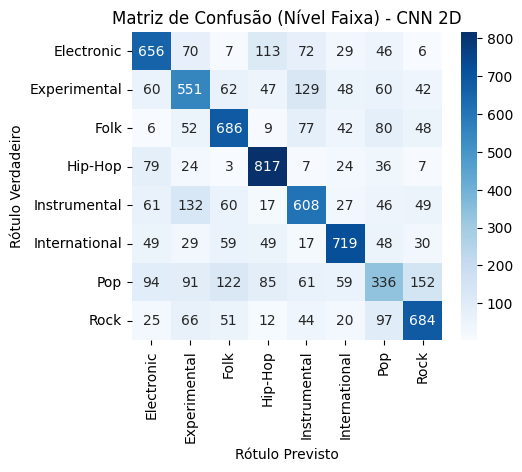

In [11]:
# Resultados da Acurácia por Faixa
mean_acc_track = np.mean(fold_scores_acc_track)
std_acc_track = np.std(fold_scores_acc_track)
print(f"\n========= Resultados Finais (Nível Faixa - Votação Majoritária) ==========")
print(f"Acurácia Média (10-Fold CV): {mean_acc_track:.4f} +/- {std_acc_track:.4f}")

# Matriz de Confusão e Relatório de Classificação Agregados (Nível Faixa)
y_true_agg = np.concatenate(all_true_track)
y_pred_agg = np.concatenate(all_preds_track)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n--- Relatório de Classificação (Nível Faixa) ---")
print(classification_report(y_true_agg, y_pred_agg, target_names=class_names))

print("\n--- Matriz de Confusão (Nível Faixa) ---")
cm = confusion_matrix(y_true_agg, y_pred_agg)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão (Nível Faixa) - CNN 2D')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()